# 快速计算多点到形状的距离

Shapely是一个几何图形运算库，它使用`ctypes`对C语言的GEOS库进行包装，提供了易于使用的调用接口。然而由于`ctypes`的调用所带来的额外开销，在大量循环中调用Shapely提供的方法将会有较大的性能损耗。本文介绍一种使用`Cython`直接调用GEOS库中的API函数的方法。该方法无需GEOS的头文件和连接库文件。

## 计算点集到多线的距离

In [ ]:
%matplotlib inline
%load_ext cython
import ctypes
import numpy as np
import pylab as pl
import shapely
import shapely.geometry as sg

首先创建一个六边形多线对象`line`和2000个随机点对象`points`。

In [2]:
angle = np.linspace(0, 2*np.pi, 7)
x, y = np.sin(angle + 0.3) * 1.5, np.cos(angle) * 1.5
line = sg.LineString(list(zip(x, y)))
px, py = np.random.normal(size=(2000, 2)).T
points = sg.MultiPoint(list(zip(px, py)))

然后使用列表推导循环计算点集中每个点到多线对象的最小距离。

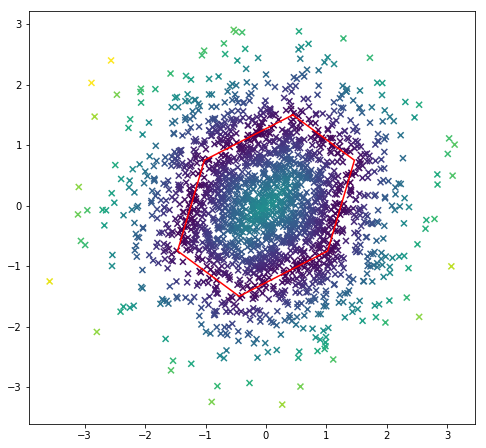

In [4]:
dist = [p.distance(line) for p in points]
fig, ax = pl.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.scatter(px, py, c=dist, marker="x")
ax.plot(x, y, "r");

下面测量运算时间：

In [5]:
%timeit [p.distance(line) for p in points]

64.4 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 查看被包装的GEOS库

`shapely.geos.lgeos`用来包装GEOS库。所有的GEOS函数的第一个参数都是一个指向GEOS环境结构体的指针。该指针指向的地址可以通过`lgeos.geos_handle`获得。

In [6]:
shapely.geos.lgeos.geos_handle

1976990091904

GEOS的所有函数都可以在`lgeos`中找到，这些函数都以`GEOS`开头：

In [7]:
function_names = [name for name in dir(shapely.geos.lgeos) if name.startswith("GEOS")]
print(function_names[:5])

['GEOSArea', 'GEOSBoundary', 'GEOSBuffer', 'GEOSBufferWithStyle', 'GEOSContains']


为了调用方便，这些函数都是都是`functools.partial`对象，它们已将`geos_handle`作为第一个参数包装起来了。

In [8]:
shapely.geos.lgeos.GEOSDistance

functools.partial(<_FuncPtr object at 0x000001CC4EC1E528>, 1976990091904)

可以通过`partial`对象的`func`获得`ctypes`函数指针。下面显示该函数的参数和返回值类型：

In [9]:
GEOSDistance = shapely.geos.lgeos.GEOSDistance.func
print(GEOSDistance.argtypes)
print(GEOSDistance.restype)

[<class 'ctypes.c_void_p'>, <class 'ctypes.c_void_p'>, <class 'ctypes.c_void_p'>, <class 'ctypes.c_void_p'>]
<class 'ctypes.c_long'>


为了获得DLL扩展库中函数的地址，可以使用`ctypes.cast()`将其转换成`c_void_p`类型，然后再通过其`value`获取该指针指向的地址，即函数的地址。

In [10]:
ctypes.cast(GEOSDistance, ctypes.c_void_p).value

140718958722960

下买了我们看看`GEOSDistance()`在`Shapely`中是如何被调用的。其第一个参数为`geos_handle`，第二、三个参数为两个表示几何图形的对象的指针，最后一个参数是指向`double`的指针，它用来返回两个几何对象之间的最小距离。

In [11]:
tmp = line.impl["distance"]
tmp??

```python
class BinaryRealProperty(Delegating):
    def __call__(self, this, other):
        self._validate(this)
        self._validate(other, stop_prepared=True)
        d = c_double()
        retval = self.fn(this._geom, other._geom, byref(d))
        return d.value
```

下面的代码确认`distance()`返回的确会调用DLL中的`GEOSDistance()`函数。

In [12]:
line.impl["distance"].fn.func, GEOSDistance

(<_FuncPtr object at 0x000001CC4EC1E528>,
 <_FuncPtr object at 0x000001CC4EC1E528>)

## 编写Cython提速程序

在Cython程序中，需要对每个使用到的GEOS API函数的类型进行声明。手工编写这些代码比较麻烦，我们用程序自动生成这些代码。生成的代码示例如下：

```cython
ctypedef long(*GEOSDistanceFunc)(void *, void *, void *, void *)
cdef GEOSDistanceFunc GEOSDistance
GEOSDistance = <GEOSDistanceFunc><unsigned long>cast(lgeos.GEOSDistance.func, c_void_p).value
```

先用`ctypedef`定义一个函数指针类型`GEOSDistanceFunc`，然后使用该类型声明一个函数指针变量`GEOSDistance`。最后将`ctypes`中的`GEOSDistance()`函数的地址赋值给该函数指针。

下面是自动生成这段`Cython`程序的代码：

In [18]:
ctypes.sizeof(ctypes.c_ulong)

4

In [19]:
import ctypes
functions = ["GEOSCoordSeq_create", 
             "GEOSCoordSeq_setX", 
             "GEOSCoordSeq_setY",
             "GEOSGeom_createPoint",
             "GEOSGeom_destroy",
             "GEOSDistance"]

type_map = {
    ctypes.c_void_p: "void *",
    ctypes.c_ulong: "unsigned long",
    ctypes.c_double: "double",
    ctypes.c_long: "long",
    None: "void"
}

for func_name in functions:
    func = getattr(shapely.geos.lgeos, func_name).func
    args = ", ".join(type_map[arg] for arg in func.argtypes)
    res = type_map[func.restype]
    type_name = func_name + "Func"
    print("ctypedef {}(*{})({})".format(res, type_name, args))
    print("cdef {} {}".format(type_name, func_name))
    print("{} = <{}><ssize_t>cast(lgeos.{}.func, c_void_p).value".format(
        func_name, type_name, func_name))
    print()

ctypedef void *(*GEOSCoordSeq_createFunc)(void *, unsigned long, unsigned long)
cdef GEOSCoordSeq_createFunc GEOSCoordSeq_create
GEOSCoordSeq_create = <GEOSCoordSeq_createFunc><ssize_t>cast(lgeos.GEOSCoordSeq_create.func, c_void_p).value

ctypedef long(*GEOSCoordSeq_setXFunc)(void *, void *, unsigned long, double)
cdef GEOSCoordSeq_setXFunc GEOSCoordSeq_setX
GEOSCoordSeq_setX = <GEOSCoordSeq_setXFunc><ssize_t>cast(lgeos.GEOSCoordSeq_setX.func, c_void_p).value

ctypedef long(*GEOSCoordSeq_setYFunc)(void *, void *, unsigned long, double)
cdef GEOSCoordSeq_setYFunc GEOSCoordSeq_setY
GEOSCoordSeq_setY = <GEOSCoordSeq_setYFunc><ssize_t>cast(lgeos.GEOSCoordSeq_setY.func, c_void_p).value

ctypedef void *(*GEOSGeom_createPointFunc)(void *, void *)
cdef GEOSGeom_createPointFunc GEOSGeom_createPoint
GEOSGeom_createPoint = <GEOSGeom_createPointFunc><ssize_t>cast(lgeos.GEOSGeom_createPoint.func, c_void_p).value

ctypedef void(*GEOSGeom_destroyFunc)(void *, void *)
cdef GEOSGeom_destroyFunc GEOSGeo

将上面自动生成的代码复制到下面的`Cython`程序中，并定义`distance()`函数计算多个点到某个几何对象的最小距离。

In [23]:
%%cython
import cython
import numpy as np
import shapely
from shapely.geos import lgeos
import ctypes
from ctypes import cast, c_void_p

ctypedef void *(*GEOSCoordSeq_createFunc)(void *, unsigned long, unsigned long)
cdef GEOSCoordSeq_createFunc GEOSCoordSeq_create
GEOSCoordSeq_create = <GEOSCoordSeq_createFunc><ssize_t>cast(lgeos.GEOSCoordSeq_create.func, c_void_p).value

ctypedef long(*GEOSCoordSeq_setXFunc)(void *, void *, unsigned long, double)
cdef GEOSCoordSeq_setXFunc GEOSCoordSeq_setX
GEOSCoordSeq_setX = <GEOSCoordSeq_setXFunc><ssize_t>cast(lgeos.GEOSCoordSeq_setX.func, c_void_p).value

ctypedef long(*GEOSCoordSeq_setYFunc)(void *, void *, unsigned long, double)
cdef GEOSCoordSeq_setYFunc GEOSCoordSeq_setY
GEOSCoordSeq_setY = <GEOSCoordSeq_setYFunc><ssize_t>cast(lgeos.GEOSCoordSeq_setY.func, c_void_p).value

ctypedef void *(*GEOSGeom_createPointFunc)(void *, void *)
cdef GEOSGeom_createPointFunc GEOSGeom_createPoint
GEOSGeom_createPoint = <GEOSGeom_createPointFunc><ssize_t>cast(lgeos.GEOSGeom_createPoint.func, c_void_p).value

ctypedef void(*GEOSGeom_destroyFunc)(void *, void *)
cdef GEOSGeom_destroyFunc GEOSGeom_destroy
GEOSGeom_destroy = <GEOSGeom_destroyFunc><ssize_t>cast(lgeos.GEOSGeom_destroy.func, c_void_p).value

ctypedef long(*GEOSDistanceFunc)(void *, void *, void *, void *)
cdef GEOSDistanceFunc GEOSDistance
GEOSDistance = <GEOSDistanceFunc><ssize_t>cast(lgeos.GEOSDistance.func, c_void_p).value

@cython.wraparound(False)
@cython.boundscheck(False)
def distance_cython(geo_obj, double[:] x, double[:] y):
    cdef int i
    cdef void * geos_h = <void *><ssize_t>lgeos.geos_handle
    cdef void * obj_h = <void *><ssize_t>geo_obj._geom
    cdef void * cs 
    cdef void * point
    cdef double dist
    cdef double[::1] result
    result = np.zeros(x.shape[0])
    cs = GEOSCoordSeq_create(geos_h, 1, 2)
    point = GEOSGeom_createPoint(geos_h, cs)
    
    for i in range(x.shape[0]):
        GEOSCoordSeq_setX(geos_h, cs, 0, x[i])
        GEOSCoordSeq_setY(geos_h, cs, 0, y[i])
        GEOSDistance(geos_h, point, obj_h, &dist)
        result[i] = dist
        
    GEOSGeom_destroy(geos_h, point)
    return result.base

在上面的`distance_cython()`函数中`geos_h`为指向GEOS环境对象的指针，`obj_h`为指向几何对象的指针，该指针所指向的地址通过`_geom`属性获取。在循环之前首先通过`GEOSCoordSeq_create()`创建一个坐标序列对象，再通过`GEOSGeom_createPoint()`创建一个坐标点对象。在循环中使用`GEOSCoordSeq_setX()`和`GEOSCoordSeq_setY()`设置该坐标点对象的坐标，最后调用`GEOSDistance()`计算坐标点到几何对象的最短距离，并将距离保存到结果数组之中。

下面测试`distance_cython()`的执行速度：

In [25]:
%timeit distance_cython(line, px, py)

8.52 ms ± 170 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


下面与Python循环得到结果比较：

In [26]:
dist2 = distance_cython(line, px, py)
np.all(dist == dist2)

True

## Numba

`Numba`可以把Python函数JIT编译成二进制代码。它能快速调用`ctypes`的函数指针对象。但由于`Numba`没有取地址的操作符`&`，下面的代码先通过`dist.ctypes.data`获取其地址`pdist`和元素的大小`itemsize`，然后使用`pdist + i * itemsize`计算每个元素的地址(注意这里由于`dist`数组的元素是连续存储的)，并传递给`GEOSDistance()`函数。

In [29]:
for func_name in functions:
    func = getattr(shapely.geos.lgeos, func_name).func
    globals()[func_name] = func

In [30]:
import numba
from numba import jit, intp, float64, carray
from numba.types import CPointer

In [31]:
@jit(float64[::1](intp, intp, float64[:], float64[:]), nopython=True)
def distance_numba(geo_h, geo_obj, x, y):
    cs = GEOSCoordSeq_create(geo_h, 1, 2)
    point = GEOSGeom_createPoint(geo_h, cs)
    dist = np.zeros_like(x)
    pdist = dist.ctypes.data
    itemsize = dist.itemsize
    
    for i in range(len(x)):
        GEOSCoordSeq_setX(geo_h, cs, 0, x[i])
        GEOSCoordSeq_setY(geo_h, cs, 0, y[i])
        GEOSDistance(geo_h, point, geo_obj, pdist + i * itemsize)
        
    GEOSGeom_destroy(geo_h, point)
    return dist

In [32]:
%timeit distance_numba(lgeos.geos_handle, line._geom, px, py)

9.37 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [33]:
np.all(dist2 == distance_numba(lgeos.geos_handle, line._geom, px, py))

True